In [1]:
import time, os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as ans 
from tqdm import tqdm 
import shutil 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import Model
from tensorflow.keras import layers 
from tensorflow.keras.layers import *
import tensorflow_datasets as tfds
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import *
from datetime import datetime
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense, Input, UpSampling2D, Conv2DTranspose, Conv2D, add, Add,\
                    Lambda, Concatenate, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, \
                    Add, LayerNormalization, Activation, LeakyReLU, SeparableConv2D, Softmax, MaxPooling2D
try:
    import tensorflow_addons as tfa 
except:
    !pip install tensorflow_addons
    import tensorflow_addons as tfa
    from tensorflow_addons.layers import InstanceNormalization
try:
    import gdown 
except:
    !pip install gdown --quiet
    import gdown
    
try: 
    from imutils import paths 
except:
    !pip install imutils  --quiet
    from imutils import paths
from collections import defaultdict
from tqdm import tqdm
import PIL
import glob
from PIL import Image
import cv2

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
IMAGE_SIZE = 128

In [12]:
def random_crop(lr_img, hr_img, hr_crop_size=128):
    lr_crop_size = hr_crop_size
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w
    hr_h = lr_h

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

In [13]:
class UnsuuportedFileExtension(Exception):
    def __init__(self, message):
        self.message = message

        
class InitializationErro(Exception):
    def __init__(self, message):
        self.message = message
        

class LOLDataLoader:
    def __init__(self, dname):
        assert dname in ["lol"], "given dataset name is not valid, supported datasets are ['lol']"  
        #assert type(resize_shape) == int, 'Unknown dtype for resize shape, needed Int' 
        #assert type(batch_size) == int, 'Unknown dtype for batch_size, needed Int' 
        self.dname = dname 
        
    def __lr_image_path(self):
        try:
            train_lr_data_path = os.path.join("lol_dataset", "our485", "low", "*.png") 
            val_lr_data_path = os.path.join("lol_dataset", "eval15", 'low', "*.png")
            return train_lr_data_path, val_lr_data_path
        
        except Exception as err:
            return err 
        
    def __hr_image_path(self):
        try: 
            train_hr_data_path = os.path.join("lol_dataset", "our485", "high", "*.png") 
            val_hr_data_path = os.path.join("lol_dataset", "eval15", 'high', "*.png") 
            return train_hr_data_path, val_hr_data_path
        
        except Exception as err:
            return err
    
    def __lr_image_files(self):
        try:
            train_lr_data_path, val_lr_data_path = self.__lr_image_path()
            files = sorted(glob.glob(train_lr_data_path))
            files_val = sorted(glob.glob(val_lr_data_path))
            return files, files_val
        
        except Exception as err:
            return err
    
    def __hr_image_files(self):
        try:
            train_hr_data_path, val_hr_data_path = self.__hr_image_path() 
            files = sorted(glob.glob(train_hr_data_path))
            files_val = sorted(glob.glob(val_hr_data_path))
            return files, files_val
        
        except Exception as err:
            return err
    
    def __train_tf_dataset(self):
        try: 
            lr_train_files, _ = self.__lr_image_files()
            hr_train_files, _ = self.__hr_image_files()
            print(lr_train_files[:4])
            tf_dataset = tf.data.Dataset.from_tensor_slices((lr_train_files, hr_train_files)) 
            return tf_dataset
        
        except Exception as err:
            return err 
    
    def __val_tf_dataset(self):
        try: 
            _, lr_val_files = self.__lr_image_files()
            _, hr_val_files = self.__hr_image_files()
            tf_dataset = tf.data.Dataset.from_tensor_slices((lr_val_files, hr_val_files)) 
            return tf_dataset 
        
        except Exception as err:
            return err
    
    def initialize(self):
        try: 
            if self.dname == "lol":
                LOL_DATA_URL = 'https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6'
                if not os.path.exists('lol_dataset'):
                    gdown.download(LOL_DATA_URL, quiet=True)
                    os.system(f'unzip -q lol_dataset')

                if (os.path.exists("lol_dataset.zip") and not os.path.exists("lol_dataset")):
                    os.system(f'unzip -q lol_dataset')
                    
        except Exception as err:
            return err 
        
    def __read_img(self, img_fpath): 
        try: 
            raw = tf.io.read_file(img_fpath)
            image = tf.image.decode_png(raw, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            return image
            
        except Exception as err:
            return err
        
    def __load_data(self, lr_img_path, hr_img_path):
        try: 
            lr_img = self.__read_img(lr_img_path)
            hr_img = self.__read_img(hr_img_path)

            return lr_img, hr_img
        
        except Exception as err:
            return err
        
    def __create_tf_dataset(self, tf_ds, batch_size, transform):
        if transform:
            print("ing")
           
            tf_ds = tf_ds.map(lambda lr, hr: random_crop(lr, hr), num_parallel_calls=tf.data.AUTOTUNE)
            tf_ds = tf_ds.map(random_flip, num_parallel_calls=tf.data.AUTOTUNE)
            tf_ds = tf_ds.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)
      #  tf_ds = tf_ds.shuffle(buffer_size=50)
        tf_ds = tf_ds.batch(batch_size, drop_remainder=True)
        tf_ds = tf_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return tf_ds
        
    def get_dataset(self, subset, batch_size, transform=True):
        assert subset in ("train", 'val'), "unsupported split type"
        try:
            if subset == "train":
                tf_ds = self.__train_tf_dataset()
                tf_ds = tf_ds.map(self.__load_data, num_parallel_calls=tf.data.AUTOTUNE).cache()
                tf_ds = self.__create_tf_dataset(tf_ds, batch_size, transform)
                return tf_ds
            
            else:
                tf_ds = self.__val_tf_dataset()
                tf_ds = tf_ds.map(self.__load_data, num_parallel_calls=tf.data.AUTOTUNE).cache()
                tf_ds = self.__create_tf_dataset(tf_ds, batch_size, transform)
                return tf_ds
                
        except Exception as err:
            print(err)
            raise InitializationErro('DataLoader, has not been initialize, use .initalize method')

In [14]:
lol_dataloder = LOLDataLoader("lol")
lol_dataloder.initialize()

In [15]:
train_ds = lol_dataloder.get_dataset("train", 2, True)
val_ds = lol_dataloder.get_dataset("val", 1, False)

['lol_dataset/our485/low/10.png', 'lol_dataset/our485/low/100.png', 'lol_dataset/our485/low/101.png', 'lol_dataset/our485/low/102.png']
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
ing


In [16]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(2, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, None, None, 3), dtype=tf.float32, name=None))>

In [17]:
for l, h in train_ds.take(1):
    print(l.shape)
    print(h.shape)

(2, 128, 128, 3)
(2, 128, 128, 3)


In [ ]:
sorted(glob.glob("./lol_dataset/our485/low/*.png"))

In [ ]:
def selective_kernel_feature_fusion(L1, L2, L3):
    n_channels =list(L1.shape)[-1]
    gap = GlobalAveragePooling2D()
    channel_downscaling_conv = Conv2D(filters=n_channels//8, kernel_size=(1,1))
    channel_upsampling_conv1 = Conv2D(filters=n_channels, kernel_size=(1, 1))
    channel_upsampling_conv2 = Conv2D(filters=n_channels, kernel_size=(1, 1))
    channel_upsampling_conv3 = Conv2D(filters=n_channels, kernel_size=(1, 1))
    
    # combining all three scale streams
    L = L1 + L2 + L3 
    # calculate the  channel-wise statistics
    s = self.gap(L)
    s =  tf.reshape(s, shape=(-1, 1, 1, n_channels))
    
    # applying channel upsampling to the z(feature vector) to get feature descriptor
    # v = feature descriptor, z = feature vector
    z = self.channel_downscaling_conv(s)
    v1 = channel_upsampling_conv1(z)
    v2 = channel_upsampling_conv2(z)
    v3 = channel_upsampling_conv3(z)
    
    # applying the softmax to v1, v2, v3, to get a attention activation.
    # s = attention activation for a feature descriptor.
    s1 = Softmax()(v1)
    s1 = Softmax()(v2)
    s1 = Softmax()(v3)
    
    # adaptively recabirating the feature maps.
    L1 = s1 * L1 
    L2 = s3 * L2 
    L3 = s3 * L3 
    
    # Global descriptor.
    U = Add()([L1, L2, L3])
    return U
        

In [ ]:
def channel_attention(M: tf.Tensor)->tf.Tensor:
    # M = feature maps.
    n_channels =list(M.shape)[-1]
    gap = GlobalAveragePooling2D()
    
    # squeeze operation, to extract the feature descriptor, by encoding global context
    d = gap(M)
    d = tf.reshape(d, shape=(-1,1,1,n_channels))
    
    # excitation operation 
    conv_1 = Conv2D(filters=n_channels//8, kernel_size=(1, 1), activation="relu")(d)
    conv_2 = Conv2D(filters=n_channels, kernel_size=(1, 1))(conv_1)
    
    # sgimoid gating, to extract the d_hat(activation)
    d_hat = sigmoid(conv_2)
    
    # rescaling the feature map with activation d_hat
    return M * d_hat

In [ ]:
def spatial_attention(M: tf.Tensor)->tf.Tensor: 
    # M = feature maps.
    gap = tf.reduce_max(M, axis=-1)
    gap = tf.expand_dims(gap, axis=-1)
        
    gmp = tf.reduce_mean(M, axis=-1)
    gmp = tf.expand_dims(gmp, axis=-1)
    
    # concat the gap output and maxpool output to generate a feature map f.
    f = Concatenate(axis=-1)([gap, gmp])
    
    # passing f to conv2 and sigmoid to get a spatial attention map.(f_hat)
    conv_out = Conv2D(filters=1, kernel_size=(1,1))(f)
    f_hat = sigmoid(conv_out)
    
    # recalibrating the feature map M, with the spatial attention map (f_hat)
    return M * f_hat

In [ ]:
def dual_attention_unit(X):
    n_channels =list(X.shape)[-1]
    
    # extract the feature maps (high-level features)
    M = Conv2D(c, kernel_size=(3,3), padding='same')(X)
    M = ReLU()(M)
    M = Conv2D(c, kernel_size=(3,3), padding='same')(M)
    
    # passing the feature map(M), to channel and spatial attention, to pass info across
    # both channels and spatial dimension of the feature tensor.(conv tensor)
    channel_rescaled_M = channel_attention(M)
    spatial_rescaled_M = spatial_attention(M)

    concat = Concatenate(axis=-1)([channel_rescaled_M, spatial_rescaled_M])
    conv_out = Conv2D(c, kernel_size=(1,1))(concat)
    return Add()([X, conv_out])

In [ ]:
def downsampling(X): 
    n_channels =list(X.shape)[-1]
    
    #upper branch (main branch)
    upper_branch = Conv2D(filters=n_channels, kernel_size=(1,1))(X)
    upper_branch = ReLU()(upper_branch)
    upper_branch = Conv2D(filters=n_channels, kernel_size=(3,3), padding='same')(upper_branch)
    upper_branch = ReLU()(upper_branch)
    
    # antialiasing downsampling using maxpooling
    upper_branch = MaxPooling2D()(upper_branch)
    upper_branch = Conv2D(filters=n_channels * 2, kernel_size=(1,1))(upper_branch)
    
    # antialiasing downsampling in skip connection.
    skip_branch = MaxPooling2D()(X)
    skip_branch = Conv2D(filters=n_channels * 2, kernel_size=(1,1))(skip_branch)

    return Add()([skip_branch, upper_branch])

In [ ]:
def upsampling(X): 
    n_channels =list(X.shape)[-1]
    
    # upprt barch upsampling with bilinear upsampler.
    upper_branch = Conv2D(filters=n_channels, kernel_size=(1,1))(X)
    upper_branch = ReLU()(upper_branch)
    upper_branch = Conv2D(filters=n_channels, kernel_size=(3,3), padding='same')(upper_branch)
    upper_branch = ReLU()(upper_branch)
    
    # bilinear upsampling (upsampling convolution).
    upper_branch = UpSampling2D()(upper_branch)
    upper_branch = Conv2D(filters=n_channels//2, kernel_size=(1, 1))(upper_branch)
    
    # bilinear upsampling for skip connection branch
    skip_branch = UpSampling2D()(X)
    skip_branch = Conv2D(filters=n_channels // 2, kernel_size=(1,1))(skip_branch)
    
    return Add()([uppor_branch, skip_branch])

In [ ]:
def multiscale_residual_block(X, channels):
    # downsampled features(multi scale streams)
    level_1 = X
    level_2 = downsampling(level_1)
    level_3 = downsampling(level_2)
    
    # appling dual attention to downsampled features
    level_1_DAU = dual_attention_unit(level_1)
    level_2_DAU = dual_attention_unit(level_2)
    level_3_DAU = dual_attention_unit(level_3)
    
    # applying the skff to dau features.
    # level1_skff = l1_dau, us(l2_dau), us(us(l3_dau))
    # level2_skff = ds(l1_dau), l2_dau, us(l3_dau)
    # level3_skff = ds(ds(l1_dau)), ds(l2_dua), l3_dau
    level_1_SKFF = selective_kernel_feature_fusion(level_1_DAU, upsampling(level_2_DAU), upsampling(upsampling(level_3_DAU)))
    level_2_SKFF = selective_kernel_feature_fusion(downsampling(level_1_DAU), level_2_DAU, upsampling(level_3_DAU))
    level_3_SKFF = selective_kernel_feature_fusion(downsampling(downsampling(level_1_DAU)), downsampling(level_2_DAU), level_3_DAU)
    
    # DAU2 
    level_1_DAU_2 = dual_attention_unit(level_1_SKFF)
    level_2_DAU_2 = upsampling((dual_attention_unit(level_2_SKFF)))
    level_3_DAU_2 = upsampling(upsampling(dual_attention_unit(level_3_SKFF)))
    
    # SKFF 2
    SKFF = selective_kernel_feature_fusion(level_1_DAU_2, level_2_DAU_2, level_3_DAU_2)
    conv = Conv2D(channels, kernel_size=(3, 3), padding="same")(SKFF)
    
    return Add()([X, conv])

In [ ]:
def recursive_residual_group(X, num_mrb, channels):
    conv_1 = Conv2D(channels, kernel_size=(3,3), padding='same')(X)
    for _ in range(num_mrb):
        conv_1 = multiscale_residual_block(conv_1, channels)
        
    conv_2 = Conv2D(channels, kernel_size=(3,3), padding='same')(conv_1)
    
    return Add()([conv_2, X])

In [ ]:
def get_mirnet(num_rrg, num_mrb, channels): 
    input_tensor = keras.Input(shape=[None, None, 3])
    X1 = Conv2D(channels, kernel_size=(3,3), padding='same')(input_tensor)
    
    for _ in range(num_rrg):
        X1 = recursive_residual_group(X1, num_mrb, channels)
    
    conv = Conv2D(3, kernel_size=(3,3), padding='same')(X1)
    output = Add()([input_tensor, conv])
        
    return keras.Model(inputs=input_tensor, outputs=output)

In [18]:
class MIRNet(keras.Model):
    """
        this class, will be used as a backbone mirnet model class, which will be backbone
        model for all image restoration tasks.
        Methods:
            selective_kernel_feature_fusion(scope: public): builds a skff block.
            channel_attention(scope: public): builds a channel attention block.
            spatial_attention(scope: public): builds a spatial attention block.
            dual_attention_unit(scope: public): builds a dual_attention_unit block.
            downsampling(scope: public): builds a downsampling block.
            upsampling(scope: public): builds a upsampling block.
            multiscale_residual_block(scope: public): builds a mrb.
            recursive_residual_group(scope: public): builds a rrg.
            
        Attrs:
            num_rrg(dtype: int): number of recursive residual groups in model.
            num_mrb(dtype: int): number of num_mrb in model.
            num_channels(dtype: int): number of num_channels groups in model.
    """
    def __init__(self, num_rrg, num_mrb, num_channels):
        super(MIRNet, self).__init__()
        self.num_rrg = num_rrg 
        self.num_mrb = num_mrb 
        self.channels = num_channels
        
    def selective_kernel_feature_fusion(self, L1, L2, L3):
        """
            this method is used for adjusting the receptive field of the neurons
            dynamically using two methods fuse and select, instead of just concatinating.
            Params:
                L1(dtype: tf.Tensor): convolutional stream1.
                L2(dtype: tf.Tensor): convolutional stream2.
                L3(dtype: tf.Tensor): convolutional stream3.
                
            Return(type: tf.Tensor): 
                returns a recalibrated convolutional sreams.
        """
        n_channels = list(L1.shape)[-1]
        gap = GlobalAveragePooling2D()
        channel_downscaling_conv = Conv2D(filters=n_channels//8, kernel_size=(1,1))
        channel_upsampling_conv1 = Conv2D(filters=n_channels, kernel_size=(1, 1))
        channel_upsampling_conv2 = Conv2D(filters=n_channels, kernel_size=(1, 1))
        channel_upsampling_conv3 = Conv2D(filters=n_channels, kernel_size=(1, 1))

        # combining all three scale streams
        L = L1 + L2 + L3 
        # calculate the  channel-wise statistics
        s = gap(L)
        s =  tf.reshape(s, shape=(-1, 1, 1, n_channels))

        # applying channel upsampling to the z(feature vector) to get feature descriptor
        # v = feature descriptor, z = feature vector
        z =  channel_downscaling_conv(s)
        v1 = channel_upsampling_conv1(z)
        v2 = channel_upsampling_conv2(z)
        v3 = channel_upsampling_conv3(z)

        # applying the softmax to v1, v2, v3, to get a attention activation.
        # s = attention activation for a feature descriptor.
        s1 = Softmax()(v1)
        s2 = Softmax()(v2)
        s3 = Softmax()(v3)

        # adaptively recabirating the feature maps.
        L1 = s1 * L1 
        L2 = s3 * L2 
        L3 = s3 * L3 

        # Global descriptor.
        U = Add()([L1, L2, L3])
        return U

    def channel_attention(self, M: tf.Tensor)->tf.Tensor:
        """
            this method, is used to  exploits the inter-channel relationships of the convolutional feature
            maps by applying squeeze and excitation operations
            Params:
                M(type: tf.Tensor): input feature maps.
            Returns(type: tf.Tensor):
                returns the calibrated feature map.
        """
        # M = feature maps.
        n_channels =list(M.shape)[-1]
        gap = GlobalAveragePooling2D()

        # squeeze operation, to extract the feature descriptor, by encoding global context
        d = gap(M)
        d = tf.reshape(d, shape=(-1,1,1,n_channels))

        # excitation operation 
        conv_1 = Conv2D(filters=n_channels//8, kernel_size=(1, 1), activation="relu")(d)
        conv_2 = Conv2D(filters=n_channels, kernel_size=(1, 1))(conv_1)

        # sgimoid gating, to extract the d_hat(activation)
        d_hat = sigmoid(conv_2)

        # rescaling the feature map with activation d_hat
        return M * d_hat
    
    def spatial_attention(self, M: tf.Tensor)->tf.Tensor: 
        """
            this method, is used to  exploits the inter-spatial dependencies of the convolutional feature
            maps by applying conv and sigmoid gating and maxpooling.
            Params:
                M(type: tf.Tensor): input feature maps.
            Returns(type: tf.Tensor):
                returns the calibrated feature map.
        """
        # M = feature maps.
        gap = tf.reduce_max(M, axis=-1)
        gap = tf.expand_dims(gap, axis=-1)

        gmp = tf.reduce_mean(M, axis=-1)
        gmp = tf.expand_dims(gmp, axis=-1)

        # concat the gap output and maxpool output to generate a feature map f.
        f = Concatenate(axis=-1)([gap, gmp])

        # passing f to conv2 and sigmoid to get a spatial attention map.(f_hat)
        conv_out = Conv2D(filters=1, kernel_size=(1,1))(f)
        f_hat = sigmoid(conv_out)

        # recalibrating the feature map M, with the spatial attention map (f_hat)
        return M * f_hat
    
    def dual_attention_unit(self, X: tf.Tensor)->tf.Tensor:
        """
            this method, is used to extract the feature map of the input image, by 
            using channel and spatial attention
            Params:
                M(type: tf.Tensor): input image.
            Returns(type: tf.Tensor):
                returns the calibrated feature map.
        """
        n_channels = list(X.shape)[-1]

        # extract the feature maps (high-level features)
        M = Conv2D(n_channels, kernel_size=(3,3), padding='same')(X)
        M = ReLU()(M)
        M = Conv2D(n_channels, kernel_size=(3,3), padding='same')(M)

        # passing the feature map(M), to channel and spatial attention, to pass info across
        # both channels and spatial dimension of the feature tensor.(conv tensor)
        channel_rescaled_M = self.channel_attention(M)
        spatial_rescaled_M = self.spatial_attention(M)

        concat = Concatenate(axis=-1)([channel_rescaled_M, spatial_rescaled_M])
        conv_out = Conv2D(n_channels, kernel_size=(1,1))(concat)
        return Add()([X, conv_out])
    
    def downsampling(self, X: tf.Tensor)->tf.Tensor: 
        """
            this method, used for downsampling the feature maps using residual blocks(main
            and skip branch), uses the antialiasing downsampling.
            Params:
                Params:
                M(type: tf.Tensor): input image.
            Returns(type: tf.Tensor):
                returns the downsampled X.
        """
        n_channels = list(X.shape)[-1]

        #upper branch (main branch)
        upper_branch = Conv2D(filters=n_channels, kernel_size=(1,1))(X)
        upper_branch = ReLU()(upper_branch)
        upper_branch = Conv2D(filters=n_channels, kernel_size=(3,3), padding='same')(upper_branch)
        upper_branch = ReLU()(upper_branch)

        # antialiasing downsampling using maxpooling
        upper_branch = MaxPooling2D()(upper_branch)
        upper_branch = Conv2D(filters=n_channels * 2, kernel_size=(1,1))(upper_branch)

        # antialiasing downsampling in skip connection.
        skip_branch = MaxPooling2D()(X)
        skip_branch = Conv2D(filters=n_channels * 2, kernel_size=(1,1))(skip_branch)

        return Add()([skip_branch, upper_branch])
    
    def upsampling(self, X: tf.Tensor)->tf.Tensor: 
        """
            this method, used for upsampling the feature maps or image using 
            residual blocks(main and skip branch), uses the BiLinear upsampling.
            Params:
                X(type: tf.Tensor): input image.
            Returns(type: tf.Tensor):
                returns the upsampled X.
        """
        n_channels = list(X.shape)[-1]

        # upprt barch upsampling with bilinear upsampler.
        upper_branch = Conv2D(filters=n_channels, kernel_size=(1,1))(X)
        upper_branch = ReLU()(upper_branch)
        upper_branch = Conv2D(filters=n_channels, kernel_size=(3,3), padding='same')(upper_branch)
        upper_branch = ReLU()(upper_branch)

        # bilinear upsampling (upsampling convolution).
        upper_branch = UpSampling2D()(upper_branch)
        upper_branch = Conv2D(filters=n_channels//2, kernel_size=(1, 1))(upper_branch)

        # bilinear upsampling for skip connection branch
        skip_branch = UpSampling2D()(X)
        skip_branch = Conv2D(filters=n_channels // 2, kernel_size=(1,1))(skip_branch)

        return Add()([upper_branch, skip_branch])
    
    def multiscale_residual_block(self, X: tf.Tensor)->tf.Tensor:
        """
            this method used to implement the multiscale residual block, which will pass 
            the input image through multiple convolution streams, to get a different scaled 
            image representation.
            Params:
                X(type: tf.Tensor): input image.
            Returns(type: tf.Tensor):
                returns the preprocesed X.
        """
        # downsampled features(multi scale streams)
        level_1 = X
        level_2 = self.downsampling(level_1)
        level_3 = self.downsampling(level_2)

        # appling dual attention to downsampled features
        level_1_DAU = self.dual_attention_unit(level_1)
        level_2_DAU = self.dual_attention_unit(level_2)
        level_3_DAU = self.dual_attention_unit(level_3)

        # applying the skff to dau features.
        # level1_skff = l1_dau, us(l2_dau), us(us(l3_dau))
        # level2_skff = ds(l1_dau), l2_dau, us(l3_dau)
        # level3_skff = ds(ds(l1_dau)), ds(l2_dua), l3_dau
        level_1_SKFF = self.selective_kernel_feature_fusion(level_1_DAU, self.upsampling(level_2_DAU),
                                                                        self.upsampling(self.upsampling(level_3_DAU)))
        
        level_2_SKFF = self.selective_kernel_feature_fusion(self.downsampling(level_1_DAU), level_2_DAU,
                                                                                            self.upsampling(level_3_DAU))
        
        level_3_SKFF = self.selective_kernel_feature_fusion(self.downsampling(self.downsampling(level_1_DAU)),
                                                                                self.downsampling(level_2_DAU), level_3_DAU)

        # DAU2 
        level_1_DAU_2 = self.dual_attention_unit(level_1_SKFF)
        level_2_DAU_2 = self.upsampling((self.dual_attention_unit(level_2_SKFF)))
        level_3_DAU_2 = self.upsampling(self.upsampling(self.dual_attention_unit(level_3_SKFF)))

        # SKFF 2
        SKFF = self.selective_kernel_feature_fusion(level_1_DAU_2, level_2_DAU_2, level_3_DAU_2)
        conv = Conv2D(self.channels, kernel_size=(3, 3), padding="same")(SKFF)

        return Add()([X, conv])
    
    def recursive_residual_group(self, X: tf.Tensor)->tf.Tensor:
        """
            this method is used to implement the recursive residual group module,
            which uses multiple multi-scale conv blocks.
            Params:
                 X(type: tf.Tensor): input image.
            Returns(type: tf.Tensor):
                returns the preprocesed X.
        """
        conv_1 = Conv2D(self.channels, kernel_size=(3,3), padding='same')(X)
        for _ in range(self.num_mrb):
            conv_1 = self.multiscale_residual_block(conv_1)

        conv_2 = Conv2D(self.channels, kernel_size=(3,3), padding='same')(conv_1)

        return Add()([conv_2, X])
    
    def get_model(self, X): 
        """
            this method, will returns the output which is generated by the recursive
            residual block, which is mir backbone output.
            Params:
                X(type: tf.Tensor): input image.
            Returns(type: tf.Tensor):
                returns the preprocesed X.
        """
        X1 = Conv2D(self.channels, kernel_size=(3,3), padding='same')(X)

        for _ in range(self.num_rrg):
            X1 = self.recursive_residual_group(X1)

        conv = Conv2D(3, kernel_size=(3,3), padding='same')(X1)
        output = Add()([X, conv])

        return output

In [20]:
model = MIRNet(num_rrg=3, num_mrb=2, num_channels=64)
inputs = Input(shape=(None, None, 3))
model = Model(inputs, model.get_model(inputs))

In [21]:
#model.summary()

model.load_weights("checkpoint/mirnet_enhancement/")

In [ ]:
class CharBonnierLoss(keras.losses.Loss):
    def __init__(self):
        super(CharBonnierLoss, self).__init__()
        
    def __call__(self, true_y, pred_y):
        loss_val = tf.reduce_mean(tf.sqrt(tf.square(true_y - pred_y) + tf.square(1e-3)))
        return loss_val
    
    
class PSNR(keras.metrics.Metric):
    def __init__(self):
        super(PSNR, self).__init__()
        
    def call(self, true_y, pred_y):
        psnr_score =  tf.image.psnr(pred_y, true_y, max_val=255.0)
        return psnr_score

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def psnr_enchancement(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)

early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor="val_psnr_enchancement",
        patience=10,
        mode='max'
    )

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        f'checkpoint/mirnet_enhancement',
        monitor="val_psnr_enchancement",
        mode="max",
        save_best_only=True,
        period=1
    )

reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
        monitor='val_psnr_enchancement',
        factor=0.5, patience=5,
        verbose=1,
        epsilon=1e-7,
        mode='max'
    )

model.compile(
        optimizer=optimizer,
        loss=charbonnier_loss,
        metrics=[psnr_enchancement]
    )

model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15,
        callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr_loss]
    )

In [3]:
def get_enchancement_model(num_rrg: int, num_mrb: int, num_channels: int)->keras.Model: 
    """
        this function, will creaate a low light enchancement model with MIRNET as a 
        backbone model.
        Params:
            num_rrg(dtype: int)      : used to specify number of recursive residual blocks
                                       in mirnet backbone.
            num_mrb(dtype: int)      : used to specify number of multi-scale stream block in
                                       inside the residual recursive group.
            num_channels(dtype: int) : used to specify the initial channels in the mirnet block.
        
        Returns(type: keras.Model)
            returns the functional keras model, for the low light enchancement.
    """
    mirnet_backbone = MIRNet(num_rrg=num_rrg,
                             num_mrb=num_mrb,
                             num_channels=num_channels
                            )
    inputs = Input(shape=(None, None, 3))
    model = Model(inputs, mirnet_backbone.get_model(inputs))
    
    return model

def get_denoising_model(num_rrg:int, num_mrb:int, num_channels: int)->keras.Model: 
    """
        this function, will creaate a image denoising model with MIRNET as a 
        backbone model.
        Params:
            num_rrg(dtype: int)      : used to specify number of recursive residual blocks
                                       in mirnet backbone.
            num_mrb(dtype: int)      : used to specify number of multi-scale stream block in
                                       inside the residual recursive group.
            num_channels(dtype: int) : used to specify the initial channels in the mirnet block.
        
        Returns(type: keras.Model)
            returns the functional keras model, for the image denoising.
    """
    mirnet_backbone = MIRNet(num_rrg=num_rrg,
                             num_mrb=num_mrb,
                             num_channels=num_channels
                            )
    inputs = Input(shape=(None, None, 3))
    model = Model(inputs, mirnet_backbone.get_model(inputs))
    
    return model

def get_super_resolution_model(num_rrg:int,
                num_mrb:int, num_channels: int, scale_factor: float)->keras.Model: 
    """
        this function, will creaate a image super resolution model with MIRNET as a 
        backbone model.
        Params:
            num_rrg(dtype: int)      : used to specify number of recursive residual blocks
                                       in mirnet backbone.
            num_mrb(dtype: int)      : used to specify number of multi-scale stream block in
                                       inside the residual recursive group.
            num_channels(dtype: int) : used to specify the initial channels in the mirnet block.
            scale_factor(dtype:float): used to specify the output resolution scale size. 
        Returns(type: keras.Model)
            returns the functional keras model, for the image super resolution.
    """
    mirnet_backbone = MIRNet(num_rrg=num_rrg,
                             num_mrb=num_mrb,
                             num_channels=num_channels
                            )
    
    inputs = Input(shape=(None, None, 3))
    out = mirnet_backbone.get_model(inputs)
    
    out = Conv2D(64 * (scale_factor ** 2), 3, padding='same')(out)
    out = tf.nn.depth_to_space(out, scale_factor)
    hr = Conv2D(3, kernel_size=(1,1))(out)

    model = Model(inputs, outputs=hr)
    
    return model

In [ ]:
def plot_res(low_light_img, ground_truth, prediction_img):
    plt.subplot(131)
    plt.imshow(low_light_img)
    plt.title("Low light Image")
    plt.axis("off")
    
    plt.subplot(132)
    plt.imshow(ground_truth)
    plt.title("Ground truth Image")
    plt.axis("off")
    
    plt.subplot(133)
    plt.imshow(prediction_img)
    plt.title("Prediction Image")
    plt.axis("off")
    plt.show()
    

for lr_img_batch, hr_img_batch in val_ds.take(10):
    print(lr_img_batch.shape)
    for i, low_light_img  in enumerate(lr_img_batch): 
        plt.figure(figsize=(12, 12))
        prediction_img = model(tf.expand_dims(low_light_img, axis=0)) # 
        plot_res(low_light_img, hr_img_batch[i], prediction_img[0])

In [ ]:
model.save("best_model/")

In [39]:
lowlight_test_images_path = 'lol_dataset/eval15/low/'

lowlight_test_images_path = 'Zero_DCE_TF/test/LIME/'

In [72]:
#lowlight_test_images_path = 'lol_dataset/eval15/low/'

for test_file in glob.glob(lowlight_test_images_path + "*.bmp"):
    print(test_file.split("/")[-1])
    filename = test_file.split("/")[-1]
    data_lowlight_path = test_file
    original_img = Image.open(data_lowlight_path)
    original_size = (np.array(original_img).shape[1], np.array(original_img).shape[0])
    original_img = (np.asarray(original_img)/255.0)

    img_lowlight = cv2.imread(data_lowlight_path)
    img_lowlight = cv2.resize(img_lowlight, (256, 256))

    enhanced_image = predict_images(model, img_lowlight)
    enhanced_image.save(f"results/LIME/{filename}")

4.bmp
0.2790396213531494
9.bmp
0.24763011932373047
5.bmp
0.24503064155578613
3.bmp
0.24383306503295898
6.bmp
0.2427663803100586
10.bmp
0.24912118911743164
2.bmp
0.24488091468811035
7.bmp
0.3693809509277344
1.bmp
0.2441699504852295
8.bmp
0.2450418472290039


In [62]:
from tensorflow.keras.preprocessing.image import img_to_array

def predict_images(model, img):
    """Predict the result based on input image and restore the image as RGB."""
  #  img = cv2.imread(filepath)
    y = img_to_array(img)
    # y = y.astype("float32") / 255.0

    inputs = np.expand_dims(y, axis=0)
    t = time.time()
    out = model.predict(inputs, verbose=False)
    print(time.time() - t)

    out_img_y = out[0]
    # out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1], 3))
    out_img = PIL.Image.fromarray(np.uint8(out_img_y))
    return out_img

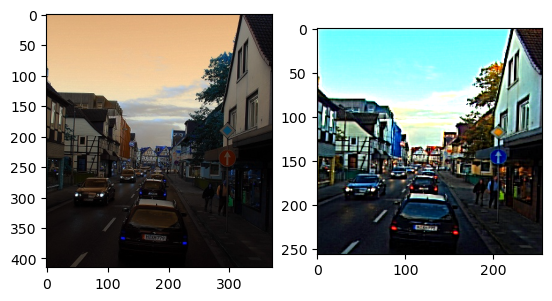

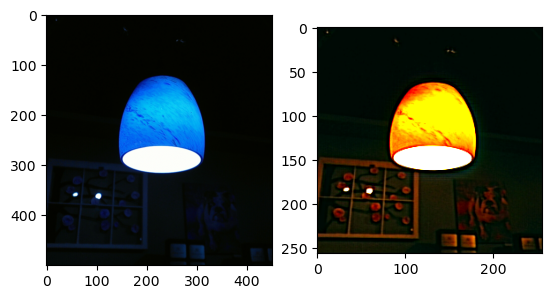

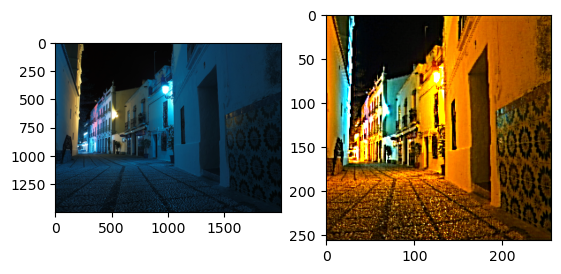

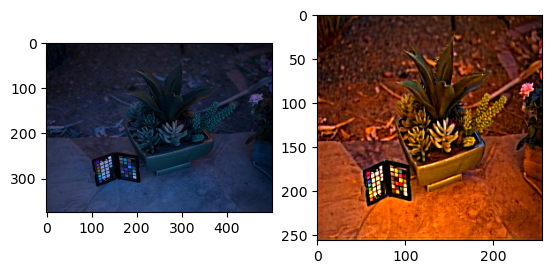

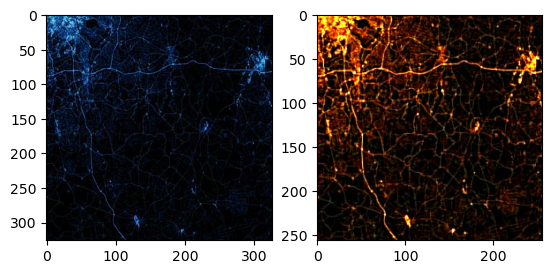

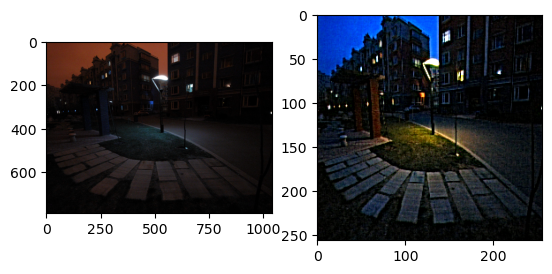

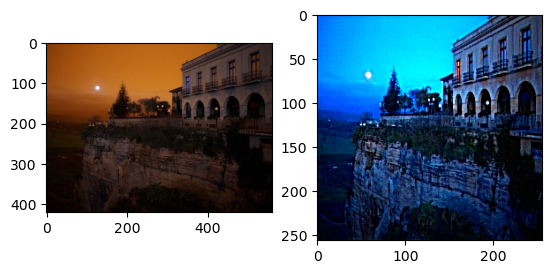

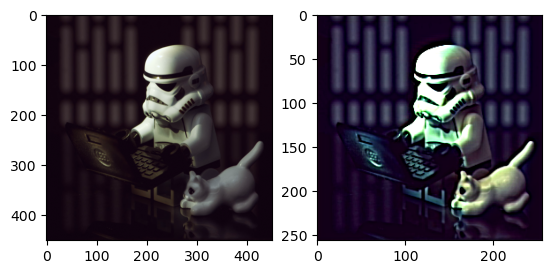

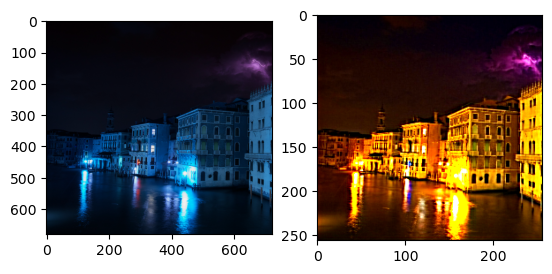

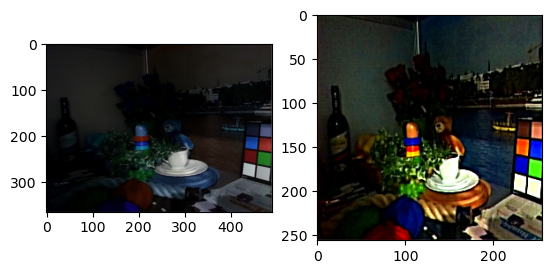

In [76]:
for test_file in (glob.glob(lowlight_test_images_path + "*.bmp")):
    filename = test_file.split("/")[-1]
    plt.figure()
    ll_img = cv2.imread(f"{lowlight_test_images_path}{filename}")
    plt.subplot(121)
    plt.imshow(ll_img/255.0)
    
    enchanced_img = cv2.imread(f"results/LIME/{filename}")
    plt.subplot(122)
    plt.imshow(enchanced_img)

In [ ]:
!wget https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2

In [ ]:
with open('SIDD_Small_sRGB_Only/Scene_Instances.txt') as f:
    instances = f.read()
    
instances = instances.split('\n')
path = 'SIDD_Small_sRGB_Only/Data/'

noisy_images_path = []
gt_images_path = []

for f in instances:
    images_path = path + f + '/'
    print(image_path)
    
    for g in os.listdir(images_path):
        image_path = images_path + g
        
        if 'NOISY' in image_path:
            noisy_images_path.append(image_path)
        else:
            gt_images_path.append(image_path)
            

print('TOTAL NOISY IMAGES:', len(noisy_images_path))
print('TOTAL GROUND TRUTH IMAGES:', len(gt_images_path))

In [ ]:
for i in range(0,len(noisy_images_path)):    
    print(noisy_images_path[i])

In [ ]:
HEIGHT = [] 
WIDTH = []

for f in tqdm(noisy_images_path):
    img = cv2.imread(f)
    height, width, channels = img.shape
    
    HEIGHT.append(height)
    WIDTH.append(width)
    
print('MIN HEIGHT:', min(HEIGHT))
print('MAX HEIGHT:', max(HEIGHT))
print()
print('MIN WIDTH:', min(WIDTH))
print('MAX WIDTH:', max(WIDTH))

In [ ]:
IMG_SIZE = 1024
size = (IMG_SIZE, IMG_SIZE)

noisy_img_array = []

for f in tqdm(noisy_images_path):
    img = cv2.imread(f)
    img = cv2.resize(img, size)
    
    noisy_img_array.append(img)
    
gt_img_array = []

for f in tqdm(gt_images_path):
    img = cv2.imread(f)
    img = cv2.resize(img, size)
    
    gt_img_array.append(img)

In [ ]:
noisy_img_array = np.array(noisy_img_array)
gt_img_array = np.array(gt_img_array)

print('NOISY IMG ARRAY:', noisy_img_array.shape)
print('GT IMG ARRAY:', gt_img_array.shape)

In [ ]:
for i in range(0,len(noisy_img_array),20):
    
    fig=plt.figure(figsize=(50, 25))
    
    ax = plt.subplot(131)
    plt.title('Ground Truth')
    plt.imshow(gt_img_array[i])
    plt.axis('off')
    
    ax = plt.subplot(132)
    plt.title('Noisy Image')
    plt.imshow(noisy_img_array[i])
    plt.axis('off')
    plt.show()
    

In [ ]:
class UnsuuportedFileExtension(Exception):
    def __init__(self, message):
        self.message = message

        
class InitializationErro(Exception):
    def __init__(self, message):
        self.message = message
        

class SIDDDataLoader:
    def __init__(self, dname):
        assert dname in ["sidd"], "given dataset name is not valid, supported datasets are ['lol']"  
        #assert type(resize_shape) == int, 'Unknown dtype for resize shape, needed Int' 
        #assert type(batch_size) == int, 'Unknown dtype for batch_size, needed Int' 
        self.dname = dname 
    
    def __image_files(self):
        try:
            with open('SIDD_Small_sRGB_Only/Scene_Instances.txt') as f:
                instances = f.read()

            instances = instances.split('\n')
            path = 'SIDD_Small_sRGB_Only/Data/'

            noisy_images_path = []
            gt_images_path = []

            for f in instances:
                images_path = path + f + '/'

                for g in os.listdir(images_path):
                    image_path = images_path + g

                    if 'NOISY' in image_path:
                        noisy_images_path.append(image_path)
                    else:
                        gt_images_path.append(image_path)

            return noisy_images_path, gt_images_path
        
        except Exception as err:
            return err
            
    def __noisy_image_files(self):
        try:
            num_train = 150
            
            noisy_images_path, _ = self.__image_files()
            train_noisy_data_path = noisy_images_path[: num_train]
            val_noisy_data_path = noisy_images_path[num_train+1: ]

            return train_noisy_data_path, val_noisy_data_path
        
        except Exception as err:
            return err
    
    def __gt_image_files(self):
        try:
            num_train = 150
            
            _, gt_images_path = self.__image_files()
            train_noisy_data_path = gt_images_path[: num_train]
            val_noisy_data_path = gt_images_path[num_train+1: ]

            return train_noisy_data_path, val_noisy_data_path
        
        except Exception as err:
            return err
    
    def __train_tf_dataset(self):
        try: 
            noisy_train_files, _ = self.__noisy_image_files()
            gt_train_files, _ = self.__gt_image_files()
            
            tf_dataset = tf.data.Dataset.from_tensor_slices((noisy_train_files, gt_train_files)) 
            return tf_dataset
        
        except Exception as err:
            return err 
    
    def __val_tf_dataset(self):
        try: 
            _, noisy_val_files = self.__noisy_image_files()
            _, gt_val_files = self.__gt_image_files()
            tf_dataset = tf.data.Dataset.from_tensor_slices((noisy_val_files, gt_val_files)) 
            return tf_dataset 
        
        except Exception as err:
            return err
    
    def initialize(self):
        try: 
            if self.dname == "ssid":
                SIDD_DATA_PATH = 'https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2'

                if not os.path.exists('SIDD_Small_sRGB_Only/Data'):
                    os.system(f'wget {SIDD_DATA_PATH}')
                    os.system(f'unzip -q a26784fe-cf33-48c2-b61f-94b299dbc0f2.1')

                if (os.path.exists("a26784fe-cf33-48c2-b61f-94b299dbc0f2.1") and not os.path.exists("SIDD_Small_sRGB_Only/")):
                    os.system(f'unzip -q a26784fe-cf33-48c2-b61f-94b299dbc0f2.1')
                    
        except Exception as err:
            return err 
        
    def __read_img(self, img_fpath): 
        try: 
            raw = tf.io.read_file(img_fpath)
            image = tf.image.decode_png(raw, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            return image
            
        except Exception as err:
            return err
        
    def __load_data(self, lr_img_path, hr_img_path):
        try: 
            lr_img = self.__read_img(lr_img_path)
            hr_img = self.__read_img(hr_img_path)

            return lr_img, hr_img
        
        except Exception as err:
            return err
        
    def __create_tf_dataset(self, tf_ds, batch_size, transform):
        if transform:
           
            tf_ds = tf_ds.map(lambda lr, hr: random_crop(lr, hr), num_parallel_calls=tf.data.AUTOTUNE)
            tf_ds = tf_ds.map(random_flip, num_parallel_calls=tf.data.AUTOTUNE)
            tf_ds = tf_ds.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)

            tf_ds = tf_ds.batch(batch_size, drop_remainder=True)
        tf_ds = tf_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return tf_ds
        
    def get_dataset(self, subset, batch_size, transform=True):
        assert subset in ("train", 'val'), "unsupported split type"
        try:
            if subset == "train":
                tf_ds = self.__train_tf_dataset()
                tf_ds = tf_ds.map(self.__load_data, num_parallel_calls=tf.data.AUTOTUNE).cache()
                tf_ds = self.__create_tf_dataset(tf_ds, batch_size, transform)
                return tf_ds
            
            else:
                tf_ds = self.__val_tf_dataset()
                tf_ds = tf_ds.map(self.__load_data, num_parallel_calls=tf.data.AUTOTUNE).cache()
                tf_ds = self.__create_tf_dataset(tf_ds, batch_size, transform)
                return tf_ds
                
        except Exception as err:
            print(err)
            raise InitializationErro('DataLoader, has not been initialize, use .initalize method')

In [ ]:
sidd_dataloader = SIDDDataLoader(dname='sidd')
sidd_dataloader.initialize()

In [ ]:
train_ds = sidd_dataloader.get_dataset("train",2, True)
val_ds = sidd_dataloader.get_dataset("val", 1, False)

In [ ]:
train_ds

In [ ]:
val_ds

In [ ]:
for noisy_img, gt_img in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(121)
    plt.imshow(noisy_img[1])
    plt.title('noisy image')
    plt.axis("off")
    
    plt.subplot(122)
    plt.imshow(gt_img[1])
    plt.title('ground truth image')
    plt.axis('off')

In [ ]:
model = get_denoising_model(num_rrg=3, num_mrb=2, num_channels=64)

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def psnr_denoising(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)

early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor="val_psnr_denoising",
        patience=5,
        mode='max'
    )

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        f'checkpoint/mirnet_denoise',
        monitor="val_psnr_denoising",
        mode="max",
        save_best_only=True,
        period=1
    )

reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
        monitor='val_psnr_denoising',
        factor=0.5,
        patience=3,
        verbose=1,
        epsilon=1e-7,
        mode='max'
    )

model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[psnr_denoising]
    )

model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr_loss]
    )

In [ ]:
!wget https://drive.google.com/file/d/1Iqx3AbUlLjR_JglsQIq9y9BEcrNLcOCU/view

In [ ]:
# Reference: https://github.com/krasserm/super-resolution/blob/master/data.py
from tensorflow import keras 
import tensorflow as tf 
import numpy as np  


def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)


import os
import tensorflow as tf
from tensorflow.python.data.experimental import AUTOTUNE

class DIV2KDataLoader:
    def __init__(self,
                 scale=2,
                 subset='train',
                 downgrade='bicubic',
                 images_dir='.div2k/images',
                 caches_dir='.div2k/caches'):

        self._ntire_2018 = True

        _scales = [2, 3, 4, 8]

        if scale in _scales:
            self.scale = scale
        else:
            raise ValueError(f'scale must be in ${_scales}')

        if subset == 'train':
            self.image_ids = range(1, 801)
        elif subset == 'valid':
            self.image_ids = range(801, 901)
        else:
            raise ValueError("subset must be 'train' or 'valid'")

        _downgrades_a = ['bicubic', 'unknown']
        _downgrades_b = ['mild', 'difficult']

        if scale == 8 and downgrade != 'bicubic':
            raise ValueError(f'scale 8 only allowed for bicubic downgrade')

        if downgrade in _downgrades_b and scale != 4:
            raise ValueError(f'{downgrade} downgrade requires scale 4')

        if downgrade == 'bicubic' and scale == 8:
            self.downgrade = 'x8'
        elif downgrade in _downgrades_b:
            self.downgrade = downgrade
        else:
            self.downgrade = downgrade
            self._ntire_2018 = False

        self.subset = subset
        self.images_dir = images_dir
        self.caches_dir = caches_dir

        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        return len(self.image_ids)

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        ds = tf.data.Dataset.zip((self.lr_dataset(), self.hr_dataset()))
        if random_transform:
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=self.scale), num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size)
        ds = ds.repeat(repeat_count)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def hr_dataset(self):
        if not os.path.exists(self._hr_images_dir()):
            download_archive(self._hr_images_archive(), self.images_dir, extract=True)

        ds = self._images_dataset(self._hr_image_files()).cache(self._hr_cache_file())

        if not os.path.exists(self._hr_cache_index()):
            self._populate_cache(ds, self._hr_cache_file())

        return ds

    def lr_dataset(self):
        if not os.path.exists(self._lr_images_dir()):
            download_archive(self._lr_images_archive(), self.images_dir, extract=True)

        ds = self._images_dataset(self._lr_image_files()).cache(self._lr_cache_file())

        if not os.path.exists(self._lr_cache_index()):
            self._populate_cache(ds, self._lr_cache_file())

        return ds

    def _hr_cache_file(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_HR.cache')

    def _lr_cache_file(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.cache')

    def _hr_cache_index(self):
        return f'{self._hr_cache_file()}.index'

    def _lr_cache_index(self):
        return f'{self._lr_cache_file()}.index'

    def _hr_image_files(self):
        images_dir = self._hr_images_dir()
        return [os.path.join(images_dir, f'{image_id:04}.png') for image_id in self.image_ids]

    def _lr_image_files(self):
        images_dir = self._lr_images_dir()
        return [os.path.join(images_dir, self._lr_image_file(image_id)) for image_id in self.image_ids]

    def _lr_image_file(self, image_id):
        if not self._ntire_2018 or self.scale == 8:
            return f'{image_id:04}x{self.scale}.png'
        else:
            return f'{image_id:04}x{self.scale}{self.downgrade[0]}.png'

    def _hr_images_dir(self):
        return os.path.join(self.images_dir, f'DIV2K_{self.subset}_HR')

    def _lr_images_dir(self):
        if self._ntire_2018:
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}')
        else:
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}', f'X{self.scale}')

    def _hr_images_archive(self):
        return f'DIV2K_{self.subset}_HR.zip'

    def _lr_images_archive(self):
        if self._ntire_2018:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}.zip'
        else:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.zip'

    @staticmethod
    def _images_dataset(image_files):
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')


def download_archive(file, target_dir, extract=True):
    source_url = f'http://data.vision.ee.ethz.ch/cvl/DIV2K/{file}'
    target_dir = os.path.abspath(target_dir)
    tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)
    os.remove(os.path.join(target_dir, file))

In [4]:
import tensorflow_datasets as tfds

In [5]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incomplete2EK7Q6/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incomplete2EK7Q6/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [6]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

In [7]:
def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=tf.data.AUTOTUNE)
    # Batching Data
    if training:
        ds = ds.batch(2)
        
    if not training:
        ds = ds.batch(1)
    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat(1)
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

In [8]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None))>

In [9]:
model = get_super_resolution_model(num_rrg=1, num_mrb=2, num_channels=32, scale_factor=4)

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def psnr_sr(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)

early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor="val_psnr_sr",
        patience=5,
        mode='max'
    )

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        f'checkpoint/psnr_sr',
        monitor="val_psnr_sr",
        mode="max",
        save_best_only=True,
        period=1
    )

reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
        monitor='val_psnr_sr',
        factor=0.5,
        patience=3,
        verbose=1,
        epsilon=1e-7,
        mode='max'
    )

model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[psnr_sr]
    )

model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=[reduce_lr_loss]
    )

Epoch 1/5
400/400 [==============================] - ETA: 0s - loss: 1663.1373 - psnr_sr: 19.4084